In [1]:
import os
import shutil

import pandas as pd
import tensorflow as tf
import numpy as np
import keras
from keras import Input
from keras.layers import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import (
    GRU,
    Conv1D,
    Dense,
    Embedding,
    Flatten,
    Lambda,
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

print(tf.__version__)

2023-02-09 16:38:07.615556: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-09 16:38:08.480535: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-02-09 16:38:08.480642: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

2.11.0


In [2]:
#read data
data = pd.read_csv("./data/train.csv")
#shuffle data
data = data.sample(frac=1)

#print data
#data.head(10)
#data["keyword"].unique()

In [3]:
#one hot encode target
classes = [[0,1][source] for source in data.target]
target = to_categorical(classes)
#print target
target[10]

array([1., 0.], dtype=float32)

In [4]:
MAX_LEN = 22
MAX_TOKENS = 100000

preprocessing_layer = TextVectorization(
    output_sequence_length=MAX_LEN, 
    max_tokens=MAX_TOKENS
    #, vocabulary = np.array(["Our","are", "in"])
)

2023-02-09 16:38:09.242012: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 16:38:09.254370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 16:38:09.256170: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-09 16:38:09.258361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [5]:
preprocessing_layer.adapt(data.text)


In [6]:
preprocessing_layer(data.text[:10])

<tf.Tensor: shape=(10, 22), dtype=int64, numpy=
array([[ 3095,   248,   447,  2035,     4,   926, 10214,  1435,    10,
          160, 14380,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [ 4542,    83,   556,  3916,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [ 2380,     8,    71,   218,     2,   337, 18435,    28,    10,
            3,   614,     4,  3542,   999,    15,    11,   406, 19860,
         1353,     0,     0,     0],
       [11301,  1645,     8,  1024,   203,   111,     6,     2,  2291,
           72,   456,   589,  2305,     9,  1442,    18,     2,   842,
           33,    16,    59,   210],
       [ 3311,   994, 19571,  1785,     5,   181,   594,     4,   616,
          384, 14773, 18173, 11034,     0,     0,     0,     0,     0,
            0,     0,     0,     0],
       [ 2915,     9,    34,  3818,    33,   331,     9, 

In [7]:
VOCAB_SIZE = len(preprocessing_layer.get_vocabulary())
VOCAB_SIZE

22699

In [8]:
inputs = Input(shape=(1,),dtype=tf.string)
x = preprocessing_layer(inputs)
x = Embedding(VOCAB_SIZE+1,5,input_shape=[22],mask_zero=True)(x)
# x= GRU(8)(x)
x = Lambda(lambda x:tf.reduce_mean(x,axis=1))(x)
# x = Dense
outputs = Dense(2,activation="softmax")(x)

model = keras.Model(inputs=inputs,outputs=outputs,name="modeltest")
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy",metrics=["Accuracy"])

Model: "modeltest"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 22)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 22, 5)             113500    
                                                                 
 lambda (Lambda)             (None, 5)                 0         
                                                                 
 dense (Dense)               (None, 2)                 12        
                                                                 
Total params: 113,512
Trainable params: 113,512
Non-trainable params: 0
___________________________________________________

In [9]:
# model = Sequential([
#     Input(shape=(1,),dtype=tf.string),
#     preprocessing_layer,
#     Embedding(
#             VOCAB_SIZE+1, 5, input_shape=[22], mask_zero=True
#     ),
#     #Lambda(lambda x:tf.reduce_mean(x,axis=1)),
#     GRU(8),
#     Dense(2,activation="softmax")
# ])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss="categorical_crossentropy",metrics=["Accuracy"])

In [10]:
modelhistory = model.fit(
    data.text[:6000],
    target[:6000], 
    epochs=50,
    batch_size=50, 
    validation_split=0.2
    # validation_data=(data.text[6000:],target[6000:]),
    # callbacks=[EarlyStopping(patience=10)]
)

Epoch 1/50


2023-02-09 16:38:12.115964: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x55ae2d493df0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-09 16:38:12.116011: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2023-02-09 16:38:12.121833: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-09 16:38:12.264167: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


96/96 [==============================] - 12s 109ms/step - loss: 0.6825 - Accuracy: 0.5575 - val_loss: 0.6661 - val_Accuracy: 0.5950
Epoch 2/50
96/96 [==============================] - 4s 38ms/step - loss: 0.6544 - Accuracy: 0.5900 - val_loss: 0.6434 - val_Accuracy: 0.6342
Epoch 3/50
96/96 [==============================] - 3s 31ms/step - loss: 0.6225 - Accuracy: 0.6619 - val_loss: 0.6186 - val_Accuracy: 0.6767
Epoch 4/50
96/96 [==============================] - 2s 20ms/step - loss: 0.5850 - Accuracy: 0.7267 - val_loss: 0.5929 - val_Accuracy: 0.7417
Epoch 5/50
96/96 [==============================] - 1s 9ms/step - loss: 0.5448 - Accuracy: 0.7948 - val_loss: 0.5672 - val_Accuracy: 0.7608
Epoch 6/50
96/96 [==============================] - 1s 9ms/step - loss: 0.5053 - Accuracy: 0.8179 - val_loss: 0.5450 - val_Accuracy: 0.7850
Epoch 7/50
96/96 [==============================] - 1s 13ms/step - loss: 0.4687 - Accuracy: 0.8448 - val_loss: 0.5257 - val_Accuracy: 0.7875
Epoch 8/50
96/96 [======

<AxesSubplot:>

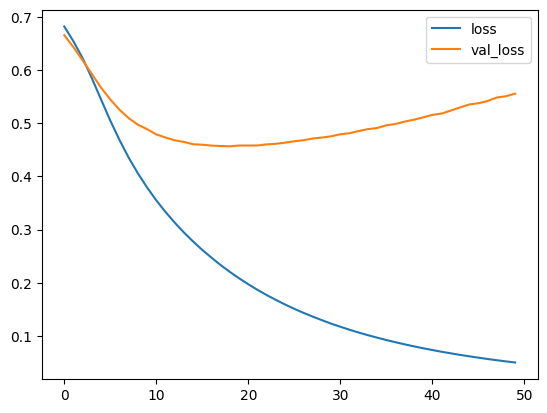

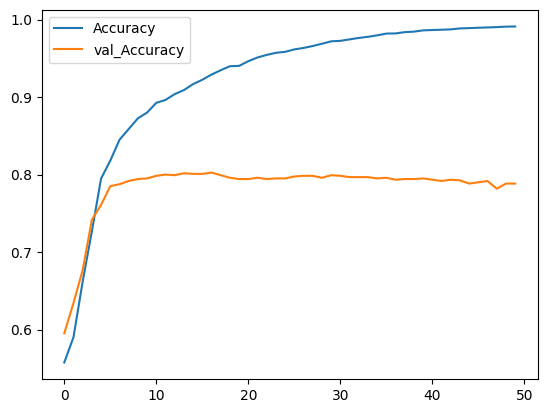

In [11]:
pd.DataFrame(modelhistory.history)[["loss","val_loss"]].plot()
pd.DataFrame(modelhistory.history)[["Accuracy","val_Accuracy"]].plot()

In [12]:
model.predict(data.text[:2])

1/1 [==============================] - 0s 104ms/step


array([[0.0013806 , 0.99861944],
       [0.5108454 , 0.4891546 ]], dtype=float32)